In [1]:
import pandas as pd
from sklearn.svm import SVR
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
# Define the objective function
def svm_objective(trial):
    
    params = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'C': trial.suggest_float('C', 1e-5, 1e5, log=True),
        'epsilon': trial.suggest_float('epsilon', 1e-5, 1e5, log=True),
    }
    
    if params['kernel'] == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 5)
    
    model = SVR(**params)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    
    return rmse

In [3]:
# Load dataset
df = pd.read_csv('test-data/2015_to_2022_dataset.csv')

In [4]:
# Replace missing values with NaN
df.replace("", np.nan, inplace=True)

In [5]:
df.isnull().sum()

Code                         0
Locale                       0
Date                         0
Temperature                  7
Precipitation            63134
Wind_Speed                  55
Wind_Direction              68
Humidity                    35
Vapor_Pressure               7
Dew_Point_Temperature       10
Spot_Atm_Pressure           21
Sea_Level_Pressure          17
Daylight_Time            32027
Insolation               31852
Snowfall_Amount          68051
Clouds_Amount             7111
Ground_Temperature          67
SO2                       1486
CO                        2672
NO2                       2074
PM10                      1436
PM2_5                     1330
O3                        1397
dtype: int64

In [6]:
# Define the columns to be imputed with the median
median_columns = [
    'Temperature', 'Wind_Speed', 'Wind_Direction', 'Humidity',
    'Vapor_Pressure', 'Dew_Point_Temperature', 'Spot_Atm_Pressure',
    'Sea_Level_Pressure', 'SO2', 'CO', 'NO2', 'PM10', 'PM2_5', 'O3',
    'Ground_Temperature'
]

# Define the columns to be imputed with zero
zeroing_columns = [
    'Precipitation', 'Daylight_Time', 'Insolation',
    'Snowfall_Amount', 'Clouds_Amount'
]

# Create imputer for median
imputer_median = SimpleImputer(strategy='median')

# Apply the imputer to the columns that require the median
df[median_columns] = imputer_median.fit_transform(df[median_columns])

# Fill the NaN values with zero for the columns that require zeroing
df[zeroing_columns] = df[zeroing_columns].fillna(0)

# Check if there are any remaining NaN values
print(df.isnull().sum())

Code                     0
Locale                   0
Date                     0
Temperature              0
Precipitation            0
Wind_Speed               0
Wind_Direction           0
Humidity                 0
Vapor_Pressure           0
Dew_Point_Temperature    0
Spot_Atm_Pressure        0
Sea_Level_Pressure       0
Daylight_Time            0
Insolation               0
Snowfall_Amount          0
Clouds_Amount            0
Ground_Temperature       0
SO2                      0
CO                       0
NO2                      0
PM10                     0
PM2_5                    0
O3                       0
dtype: int64


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%y%m%d%H')
df['Date'] = df['Date'].astype(int)

df['Year'] = df['Date'].apply(lambda x: 2000 + int(str(x)[:2]))  # Adding 2000 to get the full year, e.g., 2015
df['Month'] = df['Date'].apply(lambda x: int(str(x)[2:4]))
df['Day'] = df['Date'].apply(lambda x: int(str(x)[4:6]))
df['Hour'] = df['Date'].apply(lambda x: int(str(x)[6:]))

In [8]:
df = df.drop(columns = ['Date', 'Code', 'Locale'])

In [ ]:
df = df.drop(columns = ['SO2', 'CO','PM10','PM2_5'])

In [43]:
# Compute pairwise correlation of columns
correlation_matrix = df.corr()

In [44]:
# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


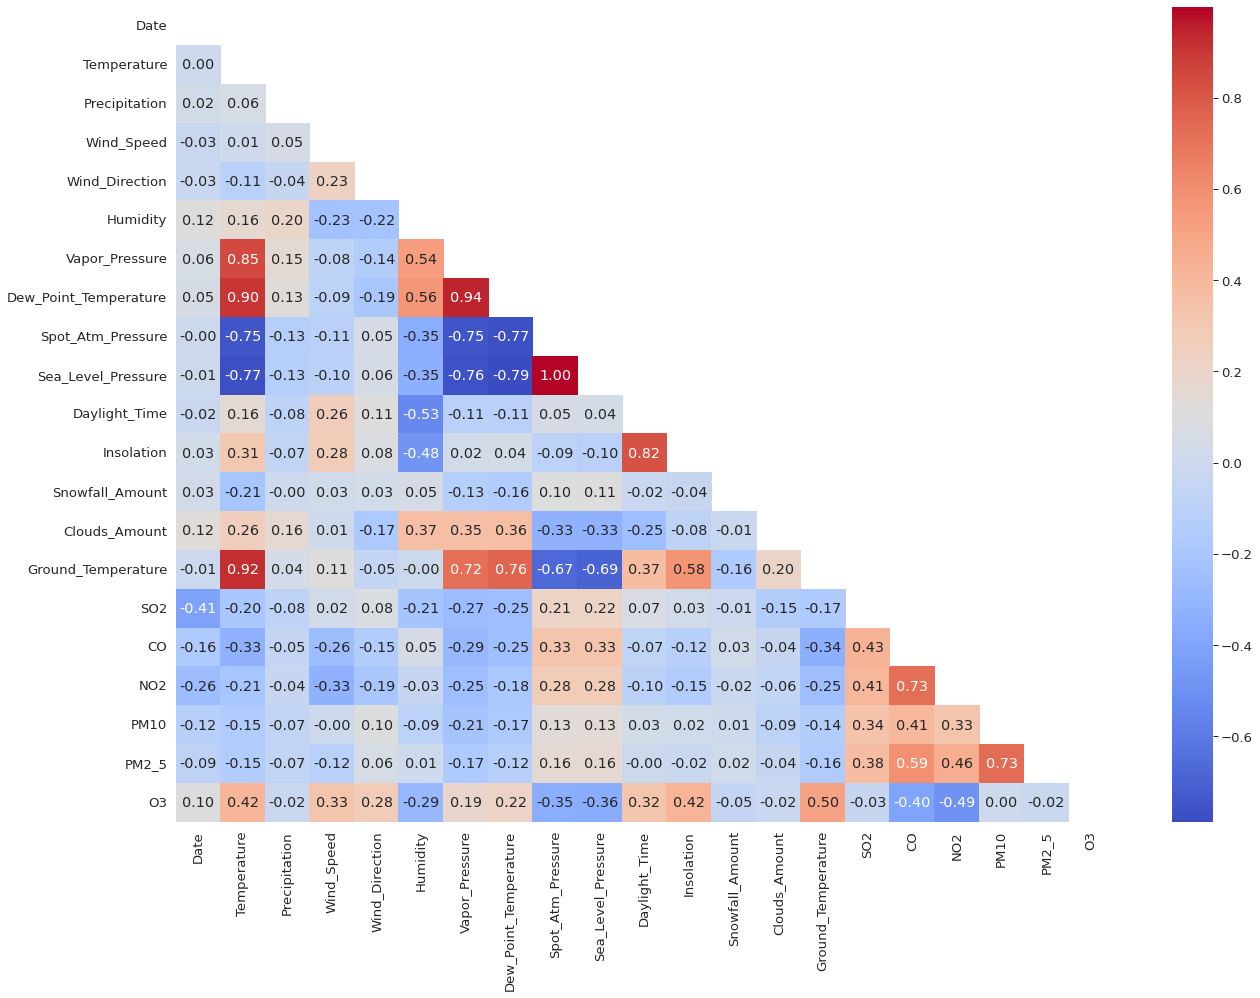

In [45]:
# Draw the heatmap with the mask
plt.figure(figsize=(21, 15))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [46]:
# Set correlation threshold
threshold = 0.8

# Find pairs of features that have a correlation higher than the threshold
highly_correlated_features = [(column1, column2) for column1 in correlation_matrix.columns 
                              for column2 in correlation_matrix.columns 
                              if (column1 != column2) and (abs(correlation_matrix[column1][column2]) > threshold)]


In [47]:
# Print highly correlated feature pairs
for pair in highly_correlated_features:
    print(pair)

('Temperature', 'Vapor_Pressure')
('Temperature', 'Dew_Point_Temperature')
('Temperature', 'Ground_Temperature')
('Vapor_Pressure', 'Temperature')
('Vapor_Pressure', 'Dew_Point_Temperature')
('Dew_Point_Temperature', 'Temperature')
('Dew_Point_Temperature', 'Vapor_Pressure')
('Spot_Atm_Pressure', 'Sea_Level_Pressure')
('Sea_Level_Pressure', 'Spot_Atm_Pressure')
('Daylight_Time', 'Insolation')
('Insolation', 'Daylight_Time')
('Ground_Temperature', 'Temperature')


In [48]:
# Calculate covariance
covariance = df.cov()['O3']
# Calculate correlation
correlation = df.corr()['O3']
# Calculate p-value
p_values = {column: pearsonr(df[column], df['O3'])[1] for column in df.columns if df[column].dtype != 'object' and column != 'O3'}

# The p-value can be used to test the hypothesis that the correlation is zero. 
# A small p-value (typically ≤ 0.05) indicates strong evidence that the correlation is significant.
# Remember that correlation measures the linear relationship between two variables, and it might not capture non-linear relationships. 
# Also, a low p-value indicates that there is evidence to reject the null hypothesis that the correlation is zero, but it doesn't quantify the magnitude or the importance of the correlation.

In [49]:
print("Covariance with O3:\n", covariance)
print("\nCorrelation with O3:\n", correlation)
print("\nP-values:\n", p_values)

Covariance with O3:
 Date                     4232.200528
Temperature                 0.088377
Precipitation              -0.000529
Wind_Speed                  0.007594
Wind_Direction              0.587145
Humidity                   -0.109863
Vapor_Pressure              0.030994
Dew_Point_Temperature       0.051313
Spot_Atm_Pressure          -0.054696
Sea_Level_Pressure         -0.058742
Daylight_Time               0.002595
Insolation                  0.006879
Snowfall_Amount            -0.000350
Clouds_Amount              -0.001919
Ground_Temperature          0.127872
SO2                        -0.000001
CO                         -0.001660
NO2                        -0.000154
PM10                        0.001609
PM2_5                      -0.005644
O3                          0.000367
Name: O3, dtype: float64

Correlation with O3:
 Date                     0.096357
Temperature              0.417487
Precipitation           -0.023143
Wind_Speed               0.325635
Wind_Direction    

In [9]:
# Specify the target variable
y = df['O3']

In [10]:
# Specify the feature variables
X = df.drop(['O3'], axis=1)

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Initialize Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(svm_objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Best hyperparameters from Optuna
best_params = study.best_params

# Train final SVM model with best hyperparameters
final_svr_model = SVR(**best_params)
final_svr_model.fit(X_train, y_train)

[I 2023-08-21 18:36:35,846] A new study created in memory with name: no-name-babaa6e4-b8b0-471f-ae9e-93e1f8a6a097
[I 2023-08-21 18:36:35,886] Trial 0 finished with value: 0.06631899510434111 and parameters: {'kernel': 'sigmoid', 'C': 0.011270821229512503, 'epsilon': 785.9842700348627}. Best is trial 0 with value: 0.06631899510434111.
[I 2023-08-21 18:36:35,909] Trial 1 finished with value: 0.06631899510434243 and parameters: {'kernel': 'rbf', 'C': 0.5475720547381749, 'epsilon': 0.2871008574832342}. Best is trial 0 with value: 0.06631899510434111.
[I 2023-08-21 18:36:35,932] Trial 2 finished with value: 0.06631899510434244 and parameters: {'kernel': 'sigmoid', 'C': 0.15973891642658009, 'epsilon': 0.7103973208547388}. Best is trial 0 with value: 0.06631899510434111.


In [13]:
# Define the hyperparameters grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Initialize SVR
svr = SVR()

# Initialize GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error',n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Initialize SVR with the best parameters
final_svr_model = grid_search.best_estimator_

# Fit the model
final_svr_model.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


KeyboardInterrupt: 

In [29]:
# Make predictions
predictions = final_svr_model.predict(X_test)

In [30]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 0.008477


In [31]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print("MAE: %f" % (mae))

MAE: 0.006747


In [32]:
# Calculate R2 Score
r2 = r2_score(y_test, predictions)
print("R2 Score: %f" % (r2))

R2 Score: 0.594951


In [ ]:
n = len(y_test)  # Number of observations
k = X_test.shape[1]  # Number of predictors

print(n)
print(k)

adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print("Adjusted R^2:", adj_r2)

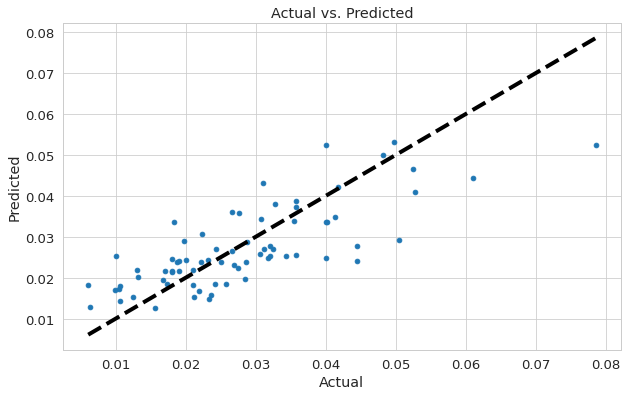

In [33]:
# Plot Actual vs. Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

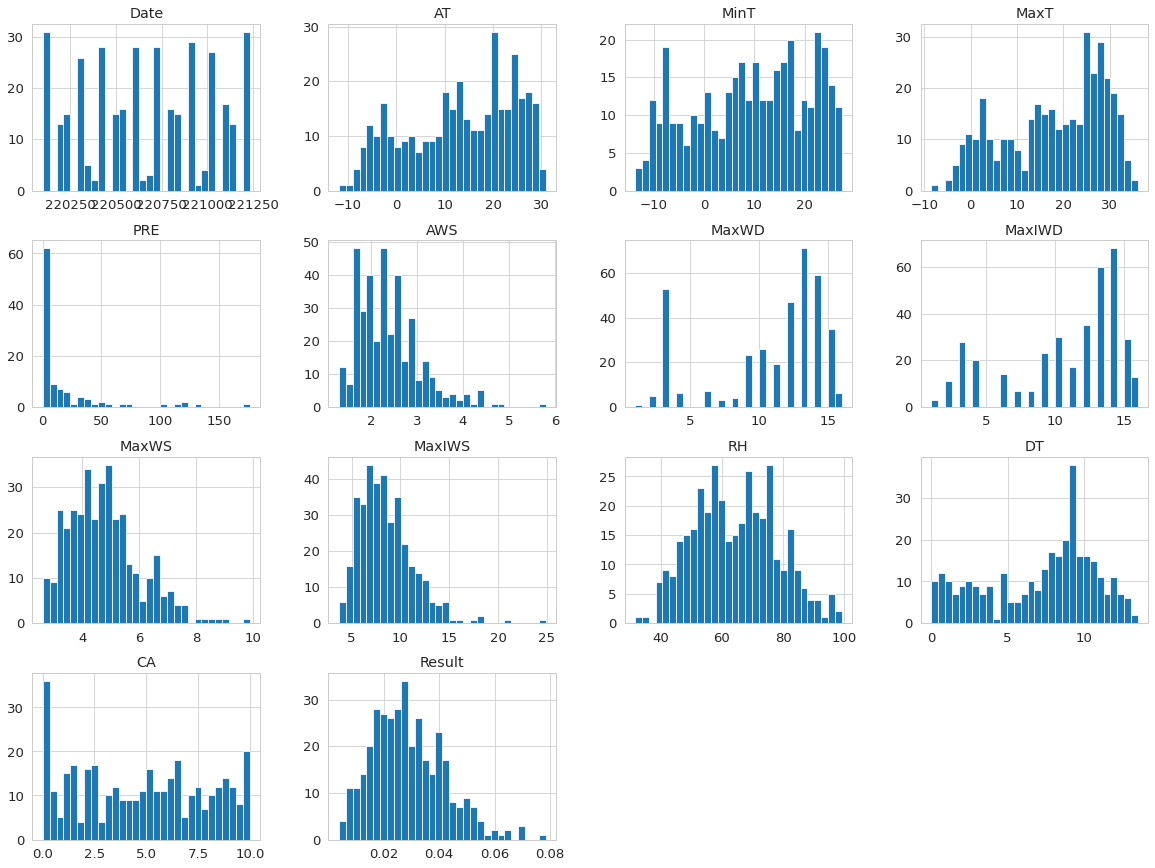

In [34]:
# Histograms for each variable in your dataset
df.hist(bins=30, figsize=(20,15))
plt.show()

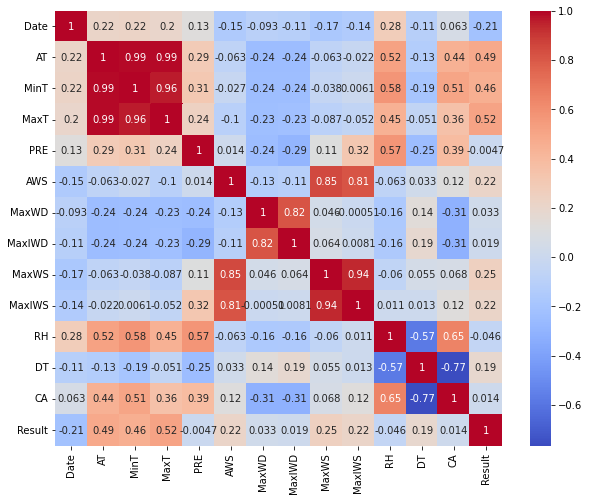

In [ ]:
# Heatmap of Correlations
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

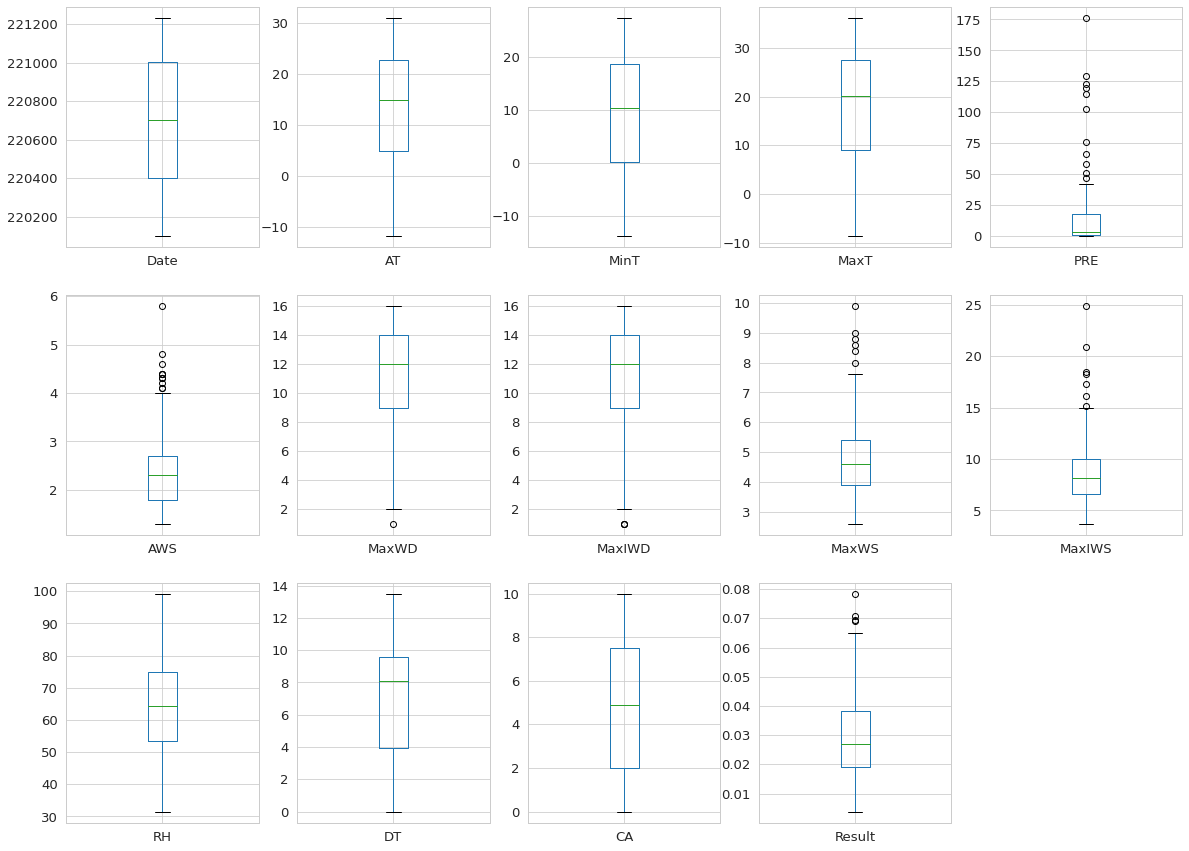

In [35]:
# Box plots for each variable
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 5, i)
    df.boxplot(column)
plt.show()